In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class MCUMovie:
    def __init__(self, movie_data):
        self.__title = movie_data.get('Movie Title', 'N/A')
        self.__release_date = movie_data.get('Release Date (USA)', 'N/A')
        self.__phase = movie_data.get('Phase', 'N/A')
        self.__genre = movie_data.get('Genre', 'N/A')
        self.__movie_rating = movie_data.get('Movie Rating', 'N/A')
        self.__lead_role = movie_data.get('Lead Role', 'N/A')
        
        self.__runtime = self._safe_convert_to_numeric(movie_data.get('Runtime (min)', None), int)
        self.__budget = self._safe_convert_to_numeric(movie_data.get('Production Budget', None), float)
        self.__box_office_local = self._safe_convert_to_numeric(movie_data.get('Box Office (Local)', None), float)
        self.__box_office_international = self._safe_convert_to_numeric(movie_data.get('Box Office (International)', None), float)
        self.__total_box_office = self._safe_convert_to_numeric(movie_data.get('Total Box Office Earnings', None), float)
        self.__rotten_tomatoes = self._safe_convert_to_numeric(movie_data.get('Rotten Tomatoes Ratings (%)', None), float)
        self.__imdb_score = self._safe_convert_to_numeric(movie_data.get('IMDb Ratings', None), float)

    def __str__(self):
        return f"MCUMovie(Title='{self.__title}', Phase='{self.__phase}', IMDb={self.__imdb_score})"

    @property
    def title(self):
        return self.__title

    @property
    def phase(self):
        return self.__phase

    @property
    def budget_usd(self):
        return self.__budget
        
    @property
    def total_box_office_usd(self):
        return self.__total_box_office

    @property
    def imdb_score(self):
        return self.__imdb_score
        
    @property
    def lead_role(self):
        return self.__lead_role
        
    @property
    def runtime_minutes(self):
        return self.__runtime

    @property
    def rotten_tomatoes_score(self):
        return self.__rotten_tomatoes
        
    @property
    def genre(self):
        return self.__genre

    @property
    def movie_rating(self):
        return self.__movie_rating
        
    @property
    def release_date(self):
        return self.__release_date

    @staticmethod
    def _safe_convert_to_numeric(value, target_type):
        try:
            if value is None or (isinstance(value, str) and value.strip() == '') or pd.isna(value):
                return None
            
            if isinstance(value, str):
                value = value.replace('$', '').replace(',', '').strip()
            
            return target_type(value)
        except (ValueError, TypeError):
            return None

    def calculate_profit(self):
        if self.budget_usd is None or self.total_box_office_usd is None:
            return None
        return self.total_box_office_usd - self.budget_usd

class MCUMovieDatabase:
    def __init__(self, db_path):
        self.db_path = db_path
        self.movies = []

    def _connect(self):
        return sqlite3.connect(self.db_path)

    def load_movies(self):
        conn = None
        try:
            conn = self._connect()
            query = "SELECT * FROM mcu_movies" 
            
            df = pd.read_sql_query(query, conn)
            
            print(f"მონაცემთა ბაზიდან ჩაიტვირთა {len(self.movies)} ფილმი.")
            for index, row in df.iterrows():
                self.movies.append(MCUMovie(row.to_dict()))
            
        except sqlite3.Error as e:
            print(f"შეცდომა მონაცემთა ბაზასთან კავშირისას ან წაკითხვისას: {e}")
        except Exception as e:
            print(f"მოულოდნელი შეცდომა მონაცემების ჩატვირთვისას: {e}")
        finally:
            if conn:
                conn.close()
                print("კავშირი მონაცემთა ბაზასთან შეწყდა.")

    def get_all_movies_df(self):
        data = []
        for movie in self.movies:
            data.append({
                'title': movie.title,
                'release_date': movie.release_date,
                'phase': movie.phase,
                'genre': movie.genre,
                'movie_rating': movie.movie_rating,
                'lead_role': movie.lead_role,
                'runtime_minutes': movie.runtime_minutes,
                'budget_usd': movie.budget_usd,
                'total_box_office_usd': movie.total_box_office_usd,
                'rotten_tomatoes_score': movie.rotten_tomatoes_score,
                'imdb_score': movie.imdb_score
            })
        return pd.DataFrame(data)

    def execute_query(self, query, params=()):
        conn = None
        try:
            conn = self._connect()
            cursor = conn.cursor()
            cursor.execute(query, params)
            conn.commit()
            print(f"ბრძანება წარმატებით შესრულდა.")
            return cursor.rowcount
        except sqlite3.Error as e:
            print(f"შეცდომა SQL ბრძანების შესრულებისას: {e}")
            return -1
        finally:
            if conn:
                conn.close()

    def fetch_data(self, query, params=(), fetch_type='all'):
        conn = None
        try:
            conn = self._connect()
            cursor = conn.cursor()
            cursor.execute(query, params)
            if fetch_type == 'one':
                return cursor.fetchone()
            elif fetch_type == 'many':
                return cursor.fetchmany(5)
            else:
                return cursor.fetchall()
        except sqlite3.Error as e:
            print(f"შეცდომა მონაცემების წაკითხვისას: {e}")
            return None
        finally:
            if conn:
                conn.close()



db_file = 'mcu_movies_db.sqlite'

db_file = 'mcu_movies_db.sqlite'
mcu_db = MCUMovieDatabase(db_file)
mcu_db.load_movies()
df_movies = mcu_db.get_all_movies_df()

df_movies['imdb_score'] = pd.to_numeric(df_movies['imdb_score'], errors='coerce')
df_movies['total_box_office_usd'] = pd.to_numeric(df_movies['total_box_office_usd'], errors='coerce')
df_movies['budget_usd'] = pd.to_numeric(df_movies['budget_usd'], errors='coerce')
df_movies.dropna(subset=['budget_usd', 'total_box_office_usd', 'imdb_score'], inplace=True)



მონაცემთა ბაზიდან ჩაიტვირთა 0 ფილმი.
კავშირი მონაცემთა ბაზასთან შეწყდა.


In [ ]:
mcu_db = MCUMovieDatabase(db_file)
mcu_db.load_movies()

df_movies = mcu_db.get_all_movies_df()

df_movies.dropna(subset=['budget_usd', 'total_box_office_usd', 'imdb_score'], inplace=True)

print("\n--- მონაცემთა საწყისი მიმოხილვა ---")
print(df_movies.head())
print("\n")
print(f"გაწმენდილი ჩანაწერების რაოდენობა: {len(df_movies)}")
print("\n")

მონაცემთა ბაზიდან ჩაიტვირთა 0 ფილმი.
კავშირი მონაცემთა ბაზასთან შეწყდა.

--- მონაცემთა საწყისი მიმოხილვა ---
                                title release_date phase  \
0  Captain America: The First Avenger  22-Jul-2011     1   
1                      Captain Marvel   8-Mar-2019     3   
2                            Iron Man   2-May-2008     1   
3                          Iron Man 2   7-May-2010     1   
4                 The Incredible Hulk  13-Jun-2008     1   

                         genre movie_rating lead_role  runtime_minutes  \
0  Action | Adventure | Sci-Fi        PG-13      Male            124.0   
1  Action | Adventure | Sci-Fi        PG-13    Female            125.0   
2  Action | Adventure | Sci-Fi        PG-13      Male            126.0   
3              Action | Sci-Fi        PG-13      Male            124.0   
4  Action | Adventure | Sci-Fi        PG-13      Male            112.0   

    budget_usd  total_box_office_usd  rotten_tomatoes_score  imdb_score  
0  14000000

In [3]:
print("--- მონაცემების წაკითხვა კონკრეტული კრიტერიუმით ---")
search_phase = input("შეიყვანეთ MCU ფაზის ნომერი (მაგ. 'Phase One'): ")
query_select_by_phase = f"SELECT `Movie Title`, `IMDb Ratings` FROM mcu_movies WHERE `Phase` = ?"
results_by_phase = mcu_db.fetch_data(query_select_by_phase, (search_phase,), fetch_type='all')

if results_by_phase:
    print(f"\nფილმები '{search_phase}' ფაზიდან:")
    for movie_title, imdb_rating in results_by_phase:
        print(f"  - {movie_title} (IMDb: {imdb_rating})")
else:
    print(f"ფაზა '{search_phase}' ვერ მოიძებნა ან შეცდომა მოხდა.")

print("\nპირველი ფილმი, რომლის IMDb რეიტინგი 8.0-ზე მეტია (fetchone):")
query_imdb_high = "SELECT `Movie Title`, `IMDb Ratings` FROM mcu_movies WHERE `IMDb Ratings` > 8.0 LIMIT 1"
result_one = mcu_db.fetch_data(query_imdb_high, fetch_type='one')
if result_one:
    print(f"  - {result_one[0]} (IMDb: {result_one[1]})")
else:
    print("ასეთი ფილმი ვერ მოიძებნა.")

print("\nრამდენიმე ფილმი, რომელთა 'Movie Rating' არის 'PG-13' (fetchmany):")
query_pg13 = "SELECT `Movie Title`, `Movie Rating` FROM mcu_movies WHERE `Movie Rating` = 'PG-13' LIMIT 5"
results_many = mcu_db.fetch_data(query_pg13, fetch_type='many')
if results_many:
    for title, rating in results_many:
        print(f"  - {title} (რეიტინგი: {rating})")
else:
    print("ასეთი ფილმები ვერ მოიძებნა.")

print("\n")

--- მონაცემების წაკითხვა კონკრეტული კრიტერიუმით ---

ფილმები '4' ფაზიდან:
  - Black Widow (IMDb: 6.7)
  - Shang-Chi and the Legend of the Ten Rings (IMDb: 7.4)
  - Eternals (IMDb: 6.3)
  - Spider-Man: No Way Home (IMDb: 8.2)
  - Doctor Strange in the Multiverse of Madness (IMDb: 6.9)
  - Thor: Love and Thunder (IMDb: 6.2)
  - Black Panther: Wakanda Forever (IMDb: 6.7)

პირველი ფილმი, რომლის IMDb რეიტინგი 8.0-ზე მეტია (fetchone):
  - Avengers: Infinity War (IMDb: 8.4)

რამდენიმე ფილმი, რომელთა 'Movie Rating' არის 'PG-13' (fetchmany):
  - Captain America: The First Avenger (რეიტინგი: PG-13)
  - Captain Marvel (რეიტინგი: PG-13)
  - Iron Man (რეიტინგი: PG-13)
  - Iron Man 2 (რეიტინგი: PG-13)
  - The Incredible Hulk (რეიტინგი: PG-13)




In [ ]:
print("--- ახალი ჩანაწერის დამატება ---")
print("შენიშვნა: შეყვანილია მხოლოდ ძირითადი ველები. სხვა ველები იქნება NULL.")
new_title = input("შეიყვანეთ ახალი ფილმის სათაური: ")
new_release_date = input("შეიყვანეთ გამოსვლის თარიღი (YYYY-MM-DD): ")
new_phase = input("შეიყვანეთ ფაზა რიცხვებში(მაგ. 'Phase Five' - 5): ")
new_imdb_rating_str = input("შეიყვანეთ IMDb რეიტინგი: ")
new_runtime_str = input("შეიყვანეთ ხანგრძლივობა წუთებში: ")

new_imdb_rating = float(new_imdb_rating_str) if new_imdb_rating_str.replace('.', '', 1).isdigit() else None
new_runtime = int(new_runtime_str) if new_runtime_str.isdigit() else None

query_insert = """
INSERT INTO mcu_movies (`Movie Title`, `Release Date (USA)`, `Phase`, `IMDb Ratings`, `Runtime (min)`, `Production Budget`, `Box Office (Local)`, `Box Office (International)`, `Total Box Office Earnings`, `Rotten Tomatoes Ratings (%)`, `Genre`, `Movie Rating`, `Lead Role`)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""
params_insert = (
    new_title, 
    new_release_date, 
    new_phase, 
    new_imdb_rating, 
    new_runtime,
    None, # Production Budget
    None, # Box Office (Local)
    None, # Box Office (International)
    None, # Total Box Office Earnings
    None, # Rotten Tomatoes Ratings (%)
    None, # Genre
    None, # Movie Rating
    None  # Lead Role
)
mcu_db.execute_query(query_insert, params_insert)


print("\n--- მონაცემთა განახლებული მიმოხილვა ---")
df_updated = mcu_db.get_all_movies_df()
print(df_updated)
print("\n")

--- ახალი ჩანაწერის დამატება ---
შენიშვნა: შეყვანილია მხოლოდ ძირითადი ველები. სხვა ველები იქნება NULL.
ბრძანება წარმატებით შესრულდა.



--- მონაცემთა განახლებული მიმოხილვა ---
                                          title  release_date phase  \
0            Captain America: The First Avenger   22-Jul-2011     1   
1                                Captain Marvel    8-Mar-2019     3   
2                                      Iron Man    2-May-2008     1   
3                                    Iron Man 2    7-May-2010     1   
4                           The Incredible Hulk   13-Jun-2008     1   
5                                          Thor    6-May-2011     1   
6                                  The Avengers    4-May-2012     1   
7                          Thor: The Dark World    8-Nov-2013     2   
8                                    Iron Man 3    3-May-2013     2   
9           Captain America: The Winter Soldier    4-Apr-2014     2   
10                      Guardians of the Ga

In [5]:
print("--- ჩანაწერის განახლება ---")
update_title = input("შეიყვანეთ ფილმის სათაური, რომლის განახლებაც გსურთ: ")
new_imdb_score_update_str = input(f"შეიყვანეთ ახალი IMDb რეიტინგი '{update_title}' ფილმისთვის: ")

new_imdb_score_update = float(new_imdb_score_update_str) if new_imdb_score_update_str.replace('.', '', 1).isdigit() else None

if new_imdb_score_update is not None:
    query_update = """
    UPDATE mcu_movies
    SET `IMDb Ratings` = ?
    WHERE `Movie Title` = ?
    """
    params_update = (new_imdb_score_update, update_title)
    mcu_db.execute_query(query_update, params_update)
else:
    print("IMDb რეიტინგი არასწორად იქნა შეყვანილი. განახლება გაუქმებულია.")

print("\n--- მონაცემთა განახლებული მიმოხილვა ---")
df_updated = mcu_db.get_all_movies_df()
print(df_updated)
print("\n")

--- ჩანაწერის განახლება ---
ბრძანება წარმატებით შესრულდა.

--- მონაცემთა განახლებული მიმოხილვა ---
                                          title  release_date phase  \
0            Captain America: The First Avenger   22-Jul-2011     1   
1                                Captain Marvel    8-Mar-2019     3   
2                                      Iron Man    2-May-2008     1   
3                                    Iron Man 2    7-May-2010     1   
4                           The Incredible Hulk   13-Jun-2008     1   
5                                          Thor    6-May-2011     1   
6                                  The Avengers    4-May-2012     1   
7                          Thor: The Dark World    8-Nov-2013     2   
8                                    Iron Man 3    3-May-2013     2   
9           Captain America: The Winter Soldier    4-Apr-2014     2   
10                      Guardians of the Galaxy    1-Aug-2014     2   
11                Guardians of the Galaxy Vol.2  

In [7]:
print("--- ჩანაწერის წაშლა ---")
delete_title = input("შეიყვანეთ ფილმის სათაური, რომლის წაშლაც გსურთ: ")
confirm_delete = input(f"ნამდვილად გსურთ '{delete_title}' ფილმის წაშლა? (დიახ/არა): ").lower()

if confirm_delete == 'დიახ':
    query_delete = """
    DELETE FROM mcu_movies
    WHERE `Movie Title` = ?
    """
    params_delete = (delete_title,)
    mcu_db.execute_query(query_delete, params_delete)
else:
    print("წაშლის ოპერაცია გაუქმებულია.")

print("\n")
print("\n--- მონაცემთა განახლებული მიმოხილვა ---")
df_updated = mcu_db.get_all_movies_df()
print(df_updated)

--- ჩანაწერის წაშლა ---
წაშლის ოპერაცია გაუქმებულია.



--- მონაცემთა განახლებული მიმოხილვა ---
                                          title  release_date phase  \
0            Captain America: The First Avenger   22-Jul-2011     1   
1                                Captain Marvel    8-Mar-2019     3   
2                                      Iron Man    2-May-2008     1   
3                                    Iron Man 2    7-May-2010     1   
4                           The Incredible Hulk   13-Jun-2008     1   
5                                          Thor    6-May-2011     1   
6                                  The Avengers    4-May-2012     1   
7                          Thor: The Dark World    8-Nov-2013     2   
8                                    Iron Man 3    3-May-2013     2   
9           Captain America: The Winter Soldier    4-Apr-2014     2   
10                      Guardians of the Galaxy    1-Aug-2014     2   
11                Guardians of the Galaxy Vol.2    5

--- 3 სხვადასხვა ტიპის დიაგრამა ---
დიაგრამა 1: Scatter Plot - ფილმების ბიუჯეტი vs. საერთო შემოსავალი


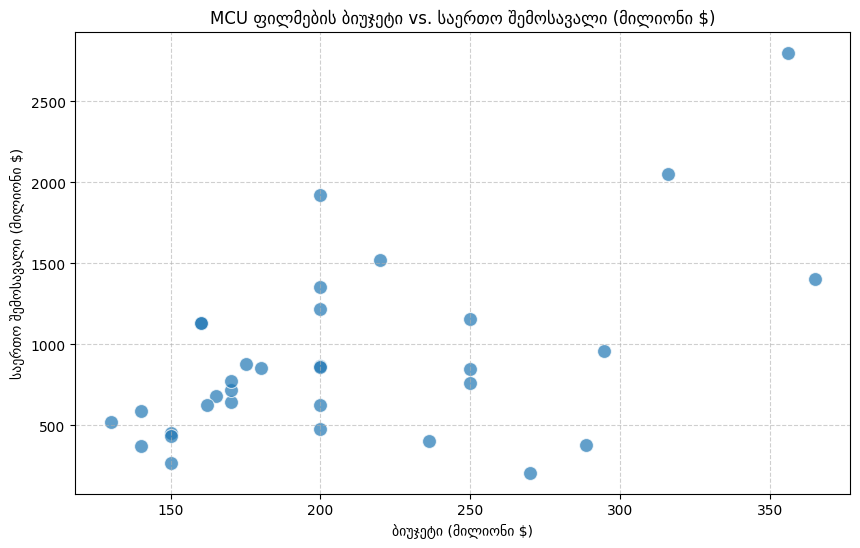

In [17]:

print("--- 3 სხვადასხვა ტიპის დიაგრამა ---")

print("დიაგრამა 1: Scatter Plot - ფილმების ბიუჯეტი vs. საერთო შემოსავალი")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_movies['budget_usd'] / 1_000_000, 
                y=df_movies['total_box_office_usd'] / 1_000_000,
                alpha=0.7, edgecolor='w', s=100)
plt.title('MCU ფილმების ბიუჯეტი vs. საერთო შემოსავალი (მილიონი $)')
plt.xlabel('ბიუჯეტი (მილიონი $)')
plt.ylabel('საერთო შემოსავალი (მილიონი $)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

დიაგრამა 2: ღერძული დიაგრამა - საშუალო IMDb რეიტინგი ფაზების მიხედვით


C:\Users\pc\AppData\Local\Temp\ipykernel_1380\3137854086.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_imdb_by_phase = df_movies.groupby('phase')['imdb_score'].mean().dropna()
C:\Users\pc\AppData\Local\Temp\ipykernel_1380\3137854086.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_imdb_by_phase.index, y=avg_imdb_by_phase.values, palette='viridis')


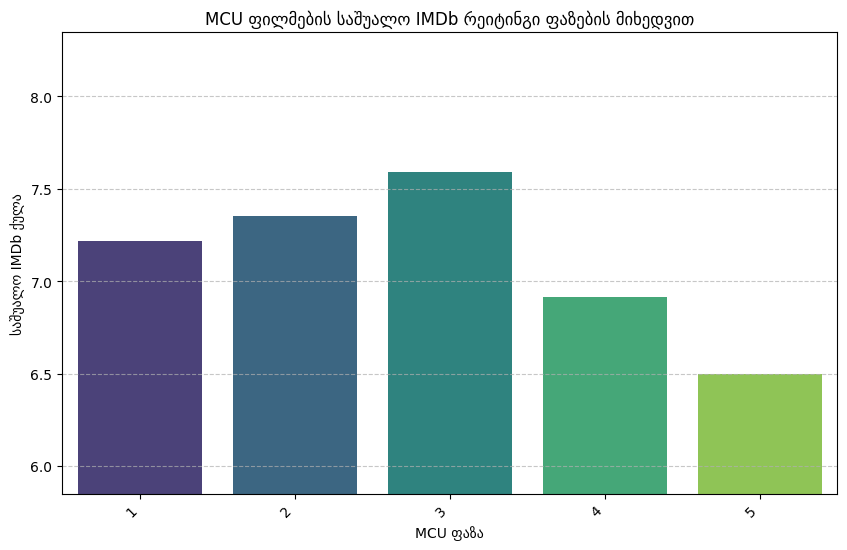

In [ ]:
print("დიაგრამა 2: ღერძული დიაგრამა - საშუალო IMDb რეიტინგი ფაზების მიხედვით")
if 'phase' in df_movies.columns and not df_movies['phase'].isnull().all():
    valid_phases = sorted(df_movies['phase'].dropna().unique())
    valid_phases = [p for p in valid_phases if p != 'N/A'] 
    
    if valid_phases:
        df_movies['phase'] = pd.Categorical(df_movies['phase'], categories=valid_phases, ordered=True)
        
        avg_imdb_by_phase = df_movies.groupby('phase')['imdb_score'].mean().dropna()

        if not avg_imdb_by_phase.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(x=avg_imdb_by_phase.index, y=avg_imdb_by_phase.values, palette='viridis')
            plt.title('MCU ფილმების საშუალო IMDb რეიტინგი ფაზების მიხედვით')
            plt.xlabel('MCU ფაზა')
            plt.ylabel('საშუალო IMDb ქულა')
            plt.ylim(min(avg_imdb_by_phase.min() * 0.9, 6.0), avg_imdb_by_phase.max() * 1.1)
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        else:
            print("ფაზების მიხედვით IMDb რეიტინგების ანალიზი ვერ მოხერხდა (მონაცემები არასაკმარისია ფილტრაციის შემდეგ).")
    else:
        print("ფაზების ანალიზი შეუძლებელია, 'phase' სვეტი არ შეიცავს ვალიდურ ფაზის სახელებს.")
else:
    print("ფაზების ანალიზი შეუძლებელია, 'phase' სვეტი არ მოიძებნა ან არ შეიცავს ვალიდურ მონაცემებს.")
`

დიაგრამა 3: ღერძული დიაგრამა - ტოპ 10 ყველაზე მაღალშემოსავლიანი ფილმი


C:\Users\pc\AppData\Local\Temp\ipykernel_1380\2216205247.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_movies_revenue['total_box_office_usd'] / 1_000_000,


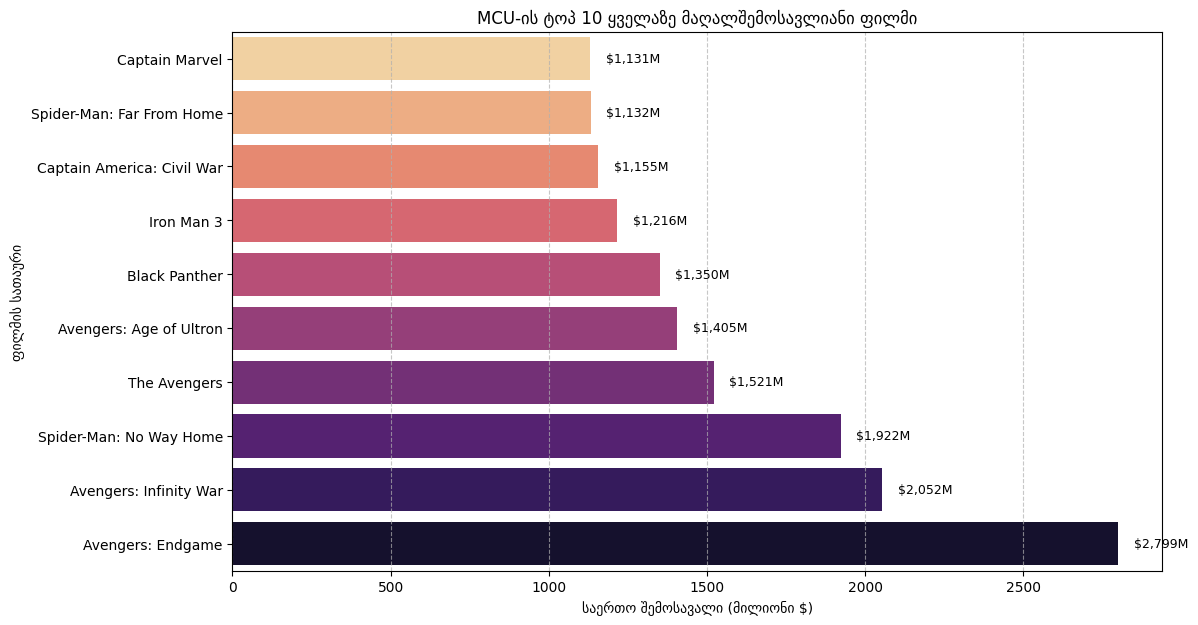

In [15]:
print("დიაგრამა 3: ღერძული დიაგრამა - ტოპ 10 ყველაზე მაღალშემოსავლიანი ფილმი")
top_10_movies_revenue = df_movies.nlargest(10, 'total_box_office_usd')

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_movies_revenue['total_box_office_usd'] / 1_000_000, 
            y=top_10_movies_revenue['title'], palette='magma')
plt.xlabel('საერთო შემოსავალი (მილიონი $)')
plt.ylabel('ფილმის სათაური')
plt.title('MCU-ის ტოპ 10 ყველაზე მაღალშემოსავლიანი ფილმი')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)
for index, value in enumerate(top_10_movies_revenue['total_box_office_usd'] / 1_000_000):
    plt.text(value + 50, index, f'${value:,.0f}M', va='center', fontsize=9)
plt.show()
